# Figure 1. Introduction to low dimensional representations of tvFC data

This notebook will generate all the elements in Figure 1. To do that it requires three files made available in ```Resources/Figure01```:

* ```winlabels_wl030_ws001.csv```: This file contains the information regarding what task was performed during each window. It contains one string (e.g., REST, VIDEO, etc) per line and has as many lines as windows.
* ```ROI_Coordinates.txt```: This file contains the coordinates for the centroid of each ROI. We need this information to sort connections on the basis of hemispheric membership.
* ```sbj06_ctask001_nroi0200_wl030_ws001.csv```: This file contains the representative timeseries for one multi-task scan.

In [29]:
from scipy.io import loadmat
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
import seaborn as sns
import plotly.express as px
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg
pn.extension('plotly')

In [2]:
from utils.data_functions import compute_SWC
from utils.basics import PRJ_DIR, task_cmap

In order to compute the Sliding Window Connectivity matrix, we need to know the repetition time (TR), the window duration and the window step. Those are defined below

In [3]:
TR      = 1.5     # TR = 1.5 sec
WL_secs = 45      # Window length in seconds
WL_trs  = int(WL_secs/TR)
WS_trs  = 1.5

Creates variable with the path where the necessary files reside

In [4]:
fig01_resource_folder = osp.join(PRJ_DIR,'Resources','Figure01')

These dictionaries will be used to atomatically set some plotting options for Plotly 3D scatter plots

In [5]:
camera = dict( up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=2, y=2, z=1))
scene_correct_le = dict(
        xaxis = dict(nticks=4, range=[-.005,.005], gridcolor="black", showbackground=True, zerolinecolor="black",backgroundcolor='rgb(230,230,230)'),
        yaxis = dict(nticks=4, range=[-.005,.005], gridcolor="black", showbackground=True, zerolinecolor="black",backgroundcolor='rgb(230,230,230)'),
        zaxis = dict(nticks=4, range=[-.005,.005], gridcolor="black", showbackground=True, zerolinecolor="black",backgroundcolor='rgb(230,230,230)'))
scene_incorrect_le = dict(
        xaxis = dict(nticks=4, range=[-.02,.02], gridcolor="black", showbackground=True, zerolinecolor="black",backgroundcolor='rgb(230,230,230)'),
        yaxis = dict(nticks=4, range=[-.02,.02], gridcolor="black", showbackground=True, zerolinecolor="black",backgroundcolor='rgb(230,230,230)'),
        zaxis = dict(nticks=4, range=[-.02,.02], gridcolor="black", showbackground=True, zerolinecolor="black",backgroundcolor='rgb(230,230,230)'))

*** 
## 1. Load ROI timeseries for one scan

In [6]:
roi_ts = pd.read_csv(osp.join(fig01_resource_folder,'sbj06_ctask001_nroi0200_wl030_ws001.csv'), index_col=[0])

In [7]:
print('++ INFO: Time series dataframe shape: % s' % str(roi_ts.shape))
roi_ts.head(5)

++ INFO: Time series dataframe shape: (1017, 157)


ROI000    ROI001    ROI002    ROI003    ROI004  \
0 days 00:00:00         0.008624 -0.016873 -0.008355 -0.028725 -0.002091   
0 days 00:00:01.500000  0.000990 -0.019260  0.018696 -0.028622  0.023398   
0 days 00:00:03         0.023629  0.004073  0.047029 -0.015933  0.026844   
0 days 00:00:04.500000  0.045177  0.047233  0.049413 -0.005833  0.021134   
0 days 00:00:06         0.019053  0.068777  0.015478 -0.012306  0.026345   

                          ROI005    ROI006    ROI007    ROI008    ROI009  ...  \
0 days 00:00:00        -0.072270 -0.003700  0.023927 -0.026399 -0.059021  ...   
0 days 00:00:01.500000 -0.047190 -0.003813 -0.005157 -0.010612 -0.024160  ...   
0 days 00:00:03         0.016941  0.023130 -0.028892  0.039986  0.054525  ...   
0 days 00:00:04.500000  0.055270  0.061556 -0.020956  0.083201  0.096749  ...   
0 days 00:00:06         0.042147  0.058840 -0.004865  0.072367  0.070982  ...   

                          ROI147    ROI148    ROI149    ROI150    ROI151  \
0 days 00:00:00        -0.072032 -0.001221 -0.095379 -0.014182 -0.009508   
0 days 00:00:01.500000 -0.065866 -0.012260 -0.113389  0.008239 -0.003895   
0 days 00:00:03        -0.014404 -0.008117 -0.070135  0.012620  0.014825   
0 days 00:00:04.500000  0.020635  0.003713 -0.015090  0.018398  0.048470   
0 days 00:00:06         0.023651  0.004034  0.034630  0.034541  0.071453   

                          ROI152    ROI153    ROI154    ROI155    ROI156  
0 days 00:00:00        -0.018833  0.036915 -0.058659 -0.058429  0.030496  
0 days 00:00:01.500000 -0.011167  0.042014 -0.025054 -0.069103  0.019217  
0 days 00:00:03         0.045039  0.021904  0.052799 -0.026508 -0.017891  
0 days 00:00:04.500000  0.093118  0.007573  0.098231  0.027209 -0.023354  
0 days 00:00:06         0.073857  0.006137  0.083602  0.052362 -0.005136  

[5 rows x 157 columns]

***
## 2. Compute Sliding Window Correlation

In [8]:
win_labels = np.loadtxt('/data/SFIMJGC_HCP7T/manifold_learning_fmri/Resources/Figure01/winlabels_wl030_ws001.csv', dtype='str')

In [9]:
%%time
swc_r,swc_Z, winInfo = compute_SWC(roi_ts,WL_trs,WS_trs,win_names=win_labels,window=None)
swc_r.index.name = 'Connections'
swc_Z.index.name = 'Connections'
print("++ INFO: Size of sliding window correlation: %s" % str(swc_r.shape))

++ INFO: Size of sliding window correlation: (12246, 988)
CPU times: user 31.7 s, sys: 1.59 s, total: 33.3 s
Wall time: 33.4 s


In [10]:
swc_r.to_csv(osp.join(PRJ_DIR,'Resources','Figure03','swcR_sbj06_ctask001_nroi0200_wl030_ws001.csv'), float_format='%.2f')
swc_Z.to_csv(osp.join(PRJ_DIR,'Resources','Figure03','swcZ_sbj06_ctask001_nroi0200_wl030_ws001.csv'), float_format='%.2f')

In [11]:
swc_r

REST      REST      REST      REST      REST      REST  \
ROI001 ROI000  0.058989  0.050161  0.069510  0.105567  0.088230  0.056185   
ROI002 ROI000  0.393602  0.367102  0.370795  0.365558  0.345845  0.363387   
       ROI001  0.478276  0.554517  0.593016  0.611048  0.615027  0.591919   
ROI003 ROI000  0.384231  0.397944  0.389773  0.399439  0.428973  0.437233   
       ROI001  0.149684  0.076485 -0.017174 -0.026733  0.049091  0.044812   
...                 ...       ...       ...       ...       ...       ...   
ROI156 ROI151 -0.088356  0.001594  0.031716  0.047878  0.129075  0.187214   
       ROI152  0.129269  0.199375  0.187292  0.185626  0.226602  0.306864   
       ROI153 -0.122110 -0.120577 -0.139771 -0.100311 -0.069432  0.059306   
       ROI154  0.170049  0.239295  0.252925  0.288360  0.397211  0.431683   
       ROI155 -0.158267 -0.033620  0.040943  0.021516  0.003954 -0.032180   

                   REST      REST      REST      REST  ...      VIDE  \
ROI001 ROI000  0.054646  0.051323  0.104337  0.145484  ... -0.118337   
ROI002 ROI000  0.356927  0.260886  0.244695  0.322380  ...  0.012702   
       ROI001  0.561025  0.593941  0.638673  0.642441  ... -0.163827   
ROI003 ROI000  0.421891  0.367971  0.380567  0.479895  ... -0.496104   
       ROI001 -0.084309 -0.165918 -0.128565 -0.085473  ...  0.052594   
...                 ...       ...       ...       ...  ...       ...   
ROI156 ROI151  0.188491  0.204163  0.211289  0.218417  ...  0.357919   
       ROI152  0.430305  0.415775  0.334720  0.303594  ... -0.346547   
       ROI153  0.128927  0.076877  0.155225  0.302488  ... -0.120734   
       ROI154  0.519482  0.485425  0.384038  0.396450  ...  0.377544   
       ROI155  0.059579  0.090774 -0.004656 -0.024360  ... -0.288322   

                   VIDE      VIDE      VIDE      VIDE      VIDE      VIDE  \
ROI001 ROI000 -0.123021 -0.150238 -0.149228 -0.147956 -0.153824 -0.174518   
ROI002 ROI000 -0.099516 -0.124459 -0.075725 -0.049976 -0.052865  0.039882   
       ROI001 -0.020906  0.043096 -0.113685 -0.125992 -0.097897 -0.167064   
ROI003 ROI000 -0.544582 -0.539974 -0.527636 -0.515524 -0.515362 -0.484703   
       ROI001  0.112120  0.104039  0.024711  0.001532  0.044289  0.013148   
...                 ...       ...       ...       ...       ...       ...   
ROI156 ROI151  0.387117  0.344984  0.289397  0.291764  0.265277  0.210113   
       ROI152 -0.421814 -0.405385 -0.372737 -0.347241 -0.350882 -0.360197   
       ROI153 -0.211786 -0.162803 -0.095187 -0.081247 -0.079300 -0.103584   
       ROI154  0.336184  0.372888  0.411508  0.412960  0.413166  0.421163   
       ROI155 -0.270829 -0.267035 -0.310986 -0.335595 -0.339569 -0.356986   

                   VIDE      VIDE      XXXX  
ROI001 ROI000 -0.097871  0.013148  0.037754  
ROI002 ROI000  0.124150  0.083801  0.065449  
       ROI001 -0.162809 -0.211233 -0.249116  
ROI003 ROI000 -0.380126 -0.344585 -0.353690  
       ROI001 -0.005668  0.000349 -0.023930  
...                 ...       ...       ...  
ROI156 ROI151  0.198490  0.202987  0.176837  
       ROI152 -0.307447 -0.271202 -0.289929  
       ROI153 -0.116789 -0.106187 -0.102510  
       ROI154  0.449548  0.450625  0.458098  
       ROI155 -0.379435 -0.374029 -0.387335  

[12246 rows x 988 columns]

For plotting purposes, we need to know what task was being performed during each window. This information is loaded now into the win_labels variable.

## 3. Compute Different Matrix Sortings

In Figure 1, we will plot the same tvFC matrix sorting connections in three different ways: 1) in descending order of mean FC, 2) in descencing order of FC volatility (as indexed by the coefficient of variance), and 3) based on hemispheric membership. The next few cells in this section will generate the appropriate indexes with each of these sorting schemes.

First, we do 1) mean and 2) volatility

In [12]:
volatility_sorting_idx = (swc_r.std(axis=1)/swc_r.mean(axis=1).abs()).sort_values(ascending=False).index
mean_sorting_idx       = swc_r.mean(axis=1).sort_values(ascending=False).index

Next, we also compute sorting of connections based on hemispheric membership

In [13]:
ROI_CMs = pd.read_csv(osp.join(fig01_resource_folder,'ROI_Coordinates.txt'), index_col='ROI_ID')

In [14]:
con_info = pd.DataFrame(index=swc_r.index,columns=['Hemi_A','Hemi_B'])
for i,j in swc_r.index:
    if ROI_CMs.loc[i,'x']<0:
        con_info.loc[(i,j),'Hemi_A'] = 'R'
    else:
        con_info.loc[(i,j),'Hemi_A'] = 'L'
    if ROI_CMs.loc[j,'x']<0:
        con_info.loc[(i,j),'Hemi_B'] = 'R'
    else:
        con_info.loc[(i,j),'Hemi_B'] = 'L'

In [15]:
LL_Cons = con_info[(con_info['Hemi_A']=='L') & (con_info['Hemi_B']=='L')].index
RR_Cons = con_info[(con_info['Hemi_A']=='R') & (con_info['Hemi_B']=='R')].index
LR_Cons = con_info[(con_info['Hemi_A']=='L') & (con_info['Hemi_B']=='R')].index
RL_Cons = con_info[(con_info['Hemi_A']=='R') & (con_info['Hemi_B']=='L')].index

***
## 4. Show SWC Matrix at scale

This is panel A in figure 1.

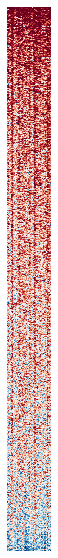

In [16]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(swc_r.loc[mean_sorting_idx],cmap='RdBu_r', vmin=-0.75, vmax=0.75, xticklabels=False, yticklabels=False, square=True, cbar=False)
ax.set(ylabel=None);

***
## 5. Show SWC matrix with different sortings

The following images correspond to panels (B), (C) and (D) in Figure 1.

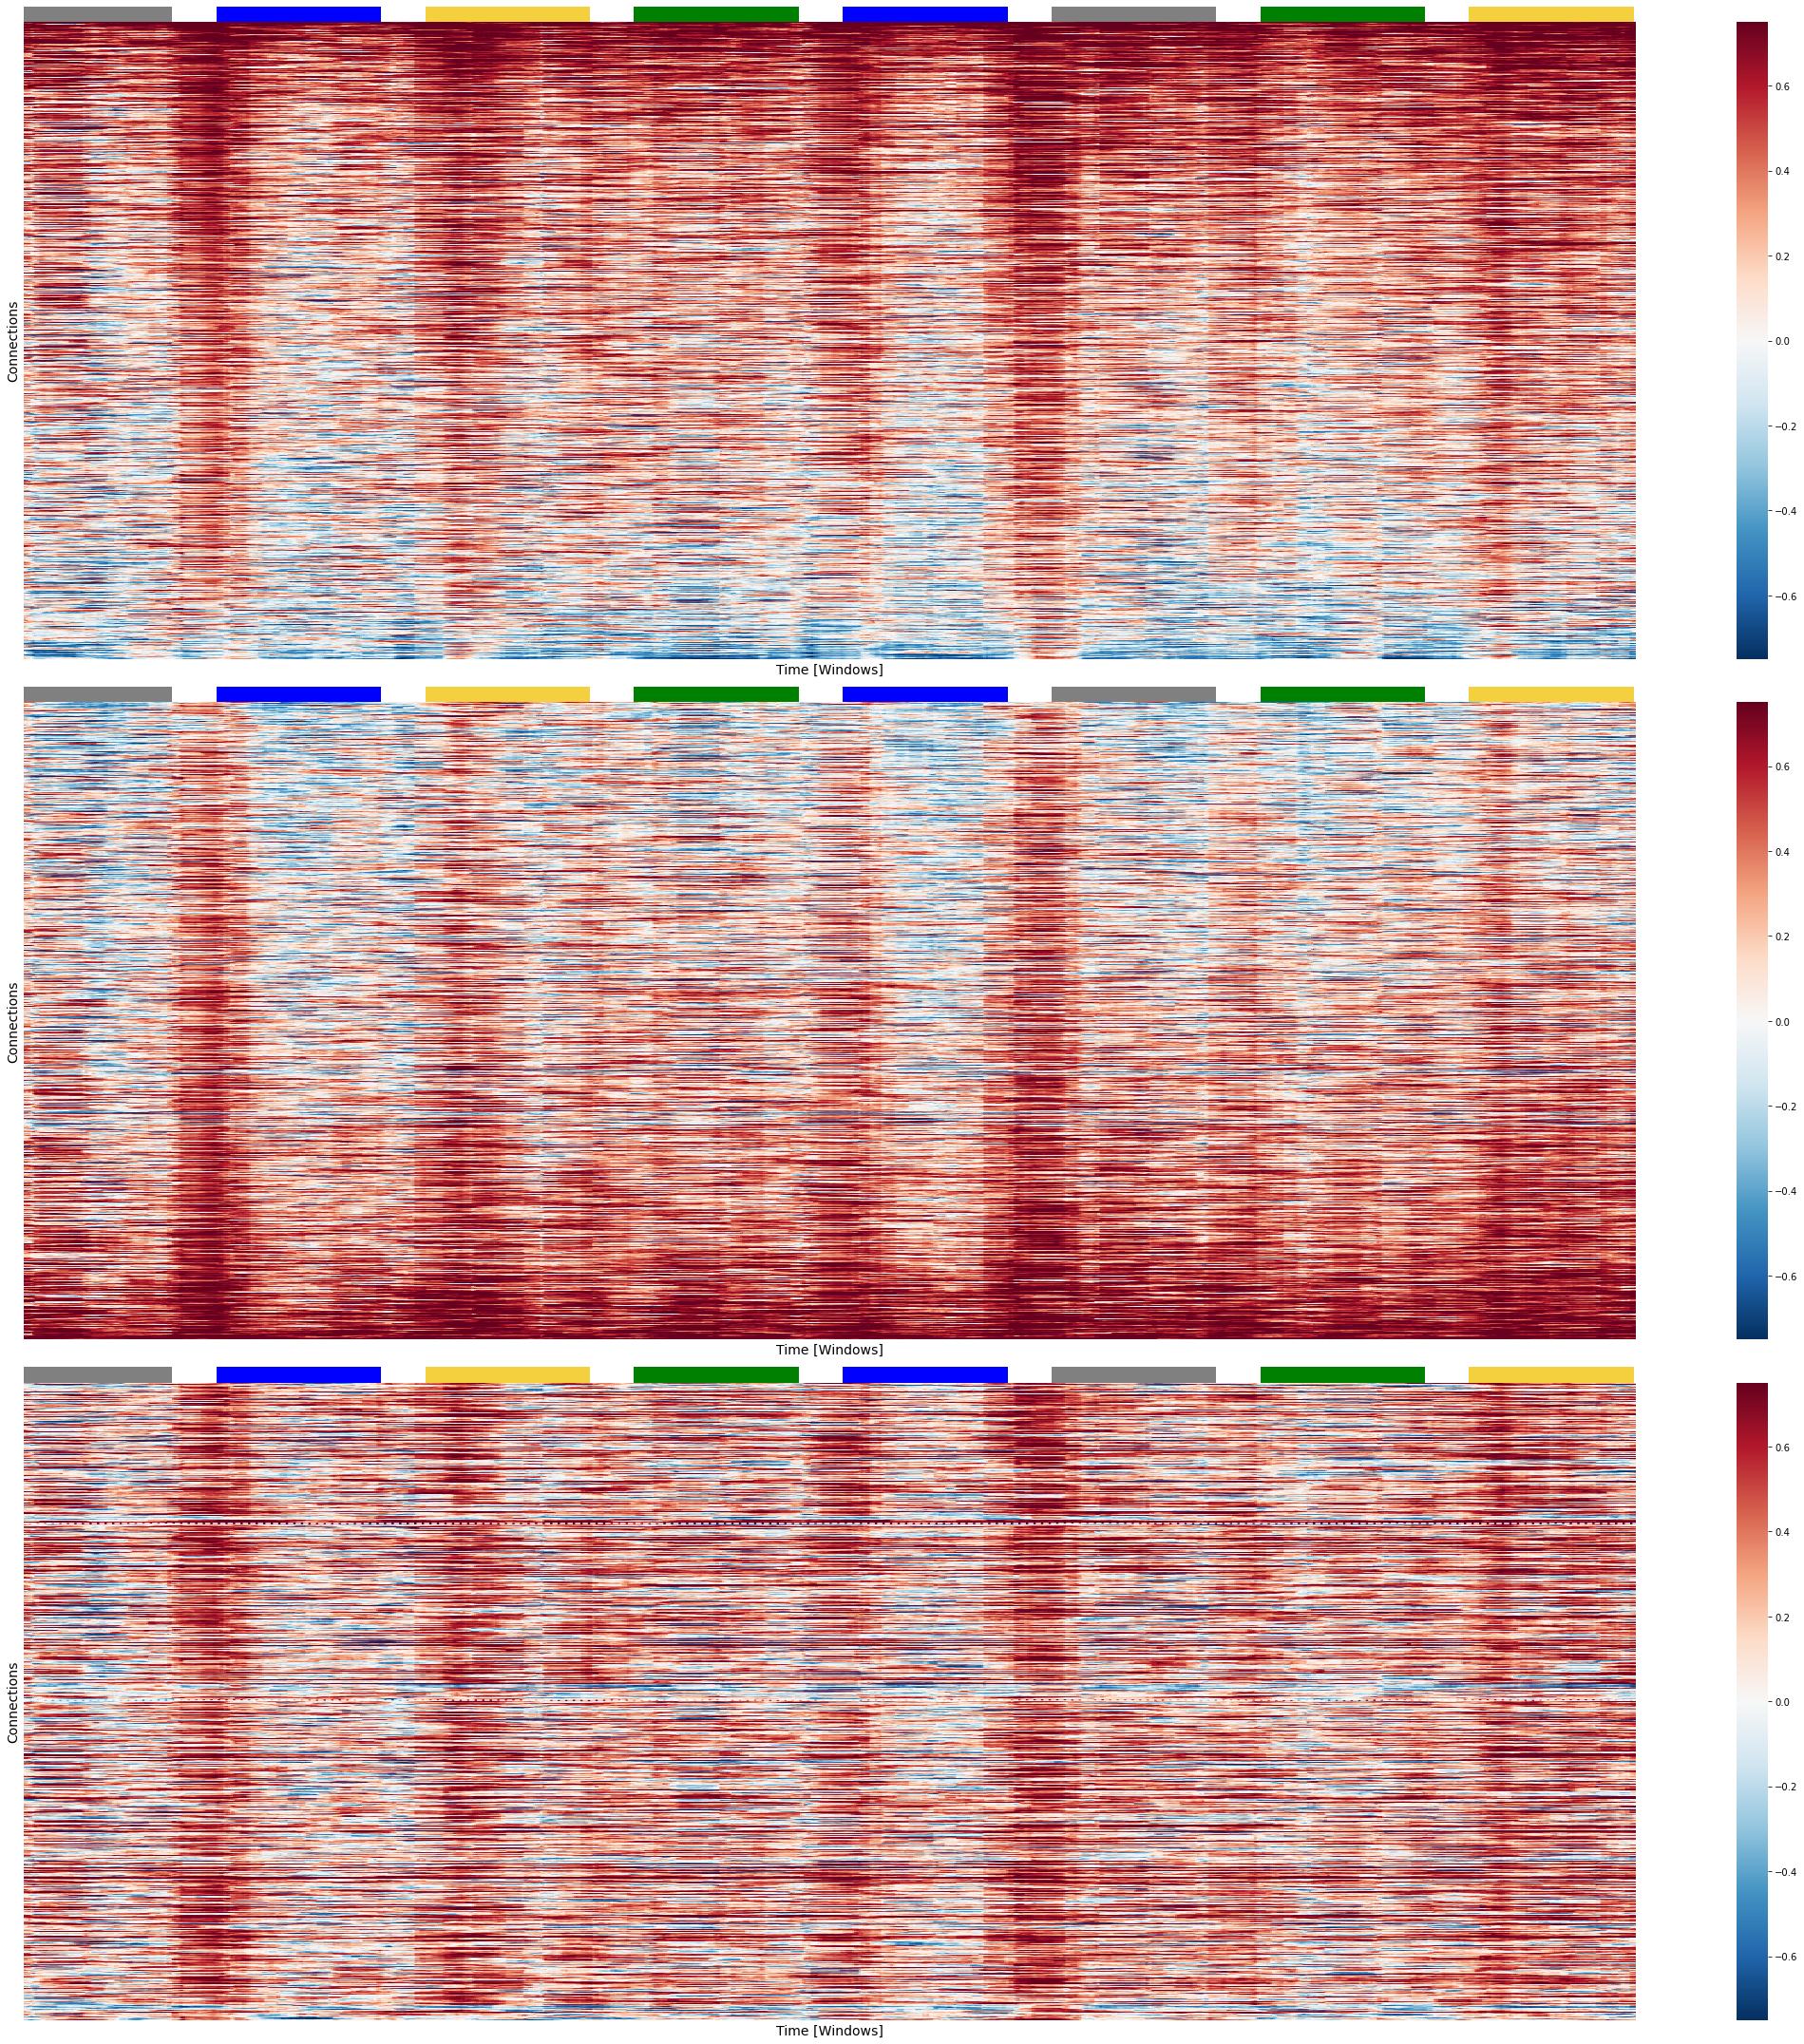

In [17]:
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(3,1,figsize=(30,30))
for i,(df,title) in enumerate(zip([swc_r.loc[mean_sorting_idx],swc_r.loc[volatility_sorting_idx],pd.concat([swc_r.loc[LL_Cons],swc_r.loc[RR_Cons],swc_r.loc[LR_Cons],swc_r.loc[RL_Cons]])],
                                ['Average Strength','Volatility','Hemisphere'])):
    plot1    = sns.heatmap(df, ax=axs[i],cmap='RdBu_r', vmin=-0.75, vmax=0.75, xticklabels=False, yticklabels=False)
    plot1.set_xlabel('Time [Windows]', fontsize=14)
    plot1.set_ylabel('Connections',    fontsize=14)
    #plot1.set_title(title, fontsize=14)
    plot1.add_patch(Rectangle((0, -301),          91, 300, fill=True, color=task_cmap['Rest'], lw=0, clip_on=False))
    plot1.add_patch(Rectangle((91+27, -301),     101, 300, fill=True, color=task_cmap['Memory'], lw=0, clip_on=False))
    plot1.add_patch(Rectangle((91+(2*27)+101, -301), 101, 300, fill=True, color=task_cmap['Video'], lw=0, clip_on=False))
    plot1.add_patch(Rectangle((91+(3*27)+(2*101), -301), 101, 300, fill=True, color=task_cmap['Math'], lw=0, clip_on=False))
    plot1.add_patch(Rectangle((91+(4*27)+(3*101), -301), 101, 300, fill=True, color=task_cmap['Memory'], lw=0, clip_on=False))
    plot1.add_patch(Rectangle((91+(5*27)+(4*101), -301), 101, 300, fill=True, color=task_cmap['Rest'], lw=0, clip_on=False))
    plot1.add_patch(Rectangle((91+(6*27)+(5*101), -301), 101, 300, fill=True, color=task_cmap['Math'], lw=0, clip_on=False))
    plot1.add_patch(Rectangle((91+(7*27)+(6*101), -301), 101, 300, fill=True, color=task_cmap['Video'], lw=0, clip_on=False))
    if i == 2:
        axs[i].hlines([LL_Cons.shape[0],LL_Cons.shape[0]+RR_Cons.shape[0]],*axs[i].get_xlim(), colors='w', linestyles='dashed')

***
## 6. Generate LE

The last four panels of figure 1 depict a two low dimensional representations of this data generated with Laplacian Eigenmaps:

* A behaviorally informative embedding generated using appropriate hyperparameters (panels E,F & G). The same low dimensional representation of the data is depicted with three different coloring schemes:
    * one color
    * colors according to task
    * colors according to time
* A non-informative embedding using an excessively low knn value.

LE representations are generated using the scikit-learn library. The necessary functions are imported next

In [18]:
from sklearn.manifold import SpectralEmbedding
from sklearn.neighbors import kneighbors_graph

We now generate an Spectral Embedding object that will generate a 3D represenation (n_components=3) and will expect a pre-computed affinity matrix. We set the random_seed to 43 for reproducibility of results

In [19]:
# Create Embedding Object
LE_obj     = SpectralEmbedding(n_components=3, affinity='precomputed', n_jobs=-1, random_state=43)

First, we create a meaningful embedding using knn=90 duirng the computation of the affinity matrix. In addition to the 3D coordinates, we add two additional columns to the resulting panda object. One contains the task information and another one timing information. These two columns are only used for plotting purposes, but do not contribute in any way to the generation of the embeddings.

In [20]:
# Create Affinity Matrix with valid neighborhood size
X_affinity_correct = pd.DataFrame(kneighbors_graph(swc_Z.T, 90, include_self=False, n_jobs=-1, metric='correlation', mode='connectivity').toarray())
X_affinity_correct = ((0.5 * (X_affinity_correct + X_affinity_correct.T)) > 0).astype(int)
# Compute Embedding based on valid neiighborhood size
LE_correct         = pd.DataFrame(LE_obj.fit_transform(X_affinity_correct),columns=['Dim_'+str(i+1).zfill(2) for i in np.arange(3)])
LE_correct['Task'] = win_labels
LE_correct['Time'] = np.arange(LE_correct.shape[0])+1

Finally, we also create a not so meaningful embedding using a excessively low knn value.

In [21]:
# Create Affinity Matrix with valid neighborhood size
X_affinity_incorrect = pd.DataFrame(kneighbors_graph(swc_Z.T, 5, include_self=False, n_jobs=-1, metric='correlation', mode='connectivity').toarray())
X_affinity_incorrect = ((0.5 * (X_affinity_incorrect + X_affinity_incorrect.T)) > 0).astype(int)
# Compute Embedding based on valid neiighborhood size
LE_incorrect         = pd.DataFrame(LE_obj.fit_transform(X_affinity_incorrect),columns=['Dim_'+str(i+1).zfill(2) for i in np.arange(3)])
LE_incorrect['Task'] = win_labels
LE_incorrect['Time'] = np.arange(LE_incorrect.shape[0])+1

Here, we now plot the different versions of these two embeddings

In [22]:
fig_nocolor = px.scatter_3d(LE_correct,x='Dim_01',y='Dim_02',z='Dim_03', width=500, height=500, opacity=0.5)
fig_nocolor.update_layout(scene_camera=camera, scene=scene_correct_le,scene_aspectmode='cube',margin=dict(l=0, r=0, b=0, t=0));
fig_time = px.scatter_3d(LE_correct,x='Dim_01',y='Dim_02',z='Dim_03', width=500, height=500, opacity=0.5, color='Time',color_continuous_scale='twilight')
fig_time.update_layout(scene_camera=camera, scene=scene_correct_le,scene_aspectmode='cube',margin=dict(l=0, r=0, b=0, t=0));
fig_task = px.scatter_3d(LE_correct,x='Dim_01',y='Dim_02',z='Dim_03', width=500, height=500, opacity=0.5, color='Task',color_discrete_sequence=['gray','black','blue','green','yellow'])
fig_task.update_layout(scene_camera=camera, scene=scene_correct_le,scene_aspectmode='cube',margin=dict(l=0, r=0, b=0, t=0));
fig_task_bad = px.scatter_3d(LE_incorrect,x='Dim_01',y='Dim_02',z='Dim_03', width=500, height=500, opacity=0.5, color='Task',color_discrete_sequence=['gray','black','blue','green','yellow'])
fig_task_bad.update_layout(scene_camera=camera,scene=scene_incorrect_le,scene_aspectmode='cube',margin=dict(l=0, r=0, b=0, t=0));

In [26]:
pn.Column(pn.Row(pn.pane.Plotly(fig_nocolor),pn.pane.Plotly(fig_time)),
          pn.Row(pn.pane.Plotly(fig_task),pn.pane.Plotly(fig_task_bad)))

Column
    [0] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [1] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)

In [27]:
# Static Version for display in github
fig_time.write_image('../Resources/Figure01/fig_time.png')
fig_nocolor.write_image('../Resources/Figure01/fig_nocolor.png')
fig_task.write_image('../Resources/Figure01/fig_task.png')
fig_task_bad.write_image('../Resources/Figure01/fig_task_bad.png')

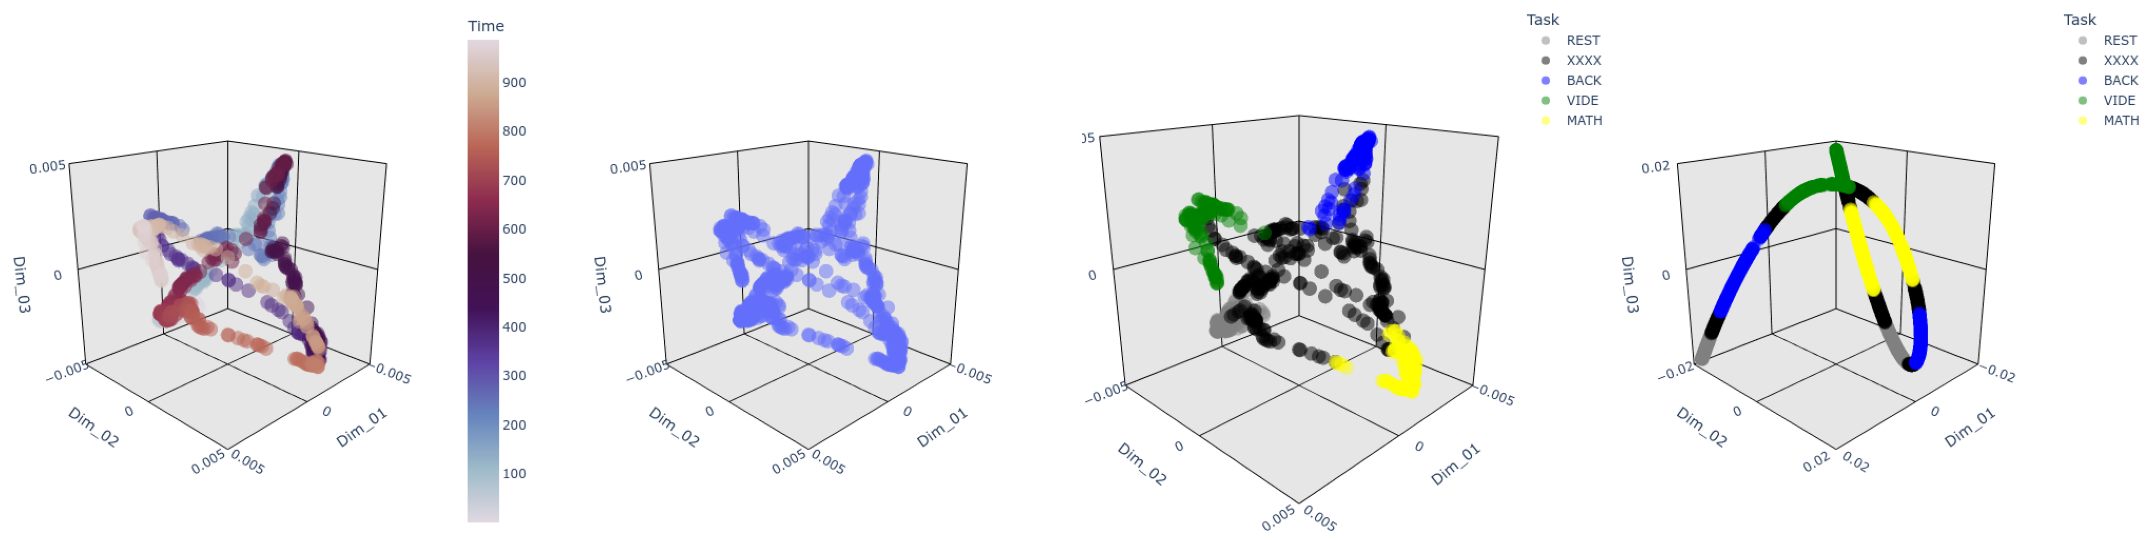

In [31]:
# Static version for github display
fig,axs = plt.subplots(1, 4, figsize=(30,10), sharex=True, sharey=True) 
for i,img_path in enumerate(['../Resources/Figure01/fig_time.png','../Resources/Figure01/fig_nocolor.png',
                        '../Resources/Figure01/fig_task.png','../Resources/Figure01/fig_task_bad.png']):
    img = mpimg.imread(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')

***
# END OF NOTEBOOK
***
The remaining of this notebook contains code that we used to generate the files now directly available in the Resources folder. 

We keep this code here for internal purposes, but should not be needed to reproduce the results shown above this cell.

### Determine Hemispheric Location of each ROI
To determine hemispheric location for each ROI, we need to run the following code
```bash
cd /data/SFIMJGC/PRJ_CognitiveStateDetection01/PrcsData/SBJ06/D02_CTask001

echo "ROI_ID,x,y,z" > ./ROI_Coordinates.txt
for t in `seq 0 1 156`
do
    xyz=`3dCM SBJ06_CTask001.Craddock_T2Level_0200.lowSigma+orig[${t}]`
    x=`echo ${xyz} | awk '{print$1}'`
    y=`echo ${xyz} | awk '{print$2}'`
    z=`echo ${xyz} | awk '{print$3}'`
    roiid=`printf "%03d" ${t}`
    echo "ROI${roiid},${x},${y},${z}" >> ./ROI_Coordinates.txt
done

```

### Selection of Subject

In [14]:
SBJ     = 'SBJ06' # Subject number
TR      = 1.5     # TR = 1.5 sec
WL_secs = 45      # Window length in seconds
WL_trs  = int(WL_secs/TR)
WS_trs  = 10

### Load ROI Timeseries, TR and WinInfo

In [15]:
file_name  = SBJ+'_CTask001_WL0'+str(WL_secs)+'_WS01_NROI0200_dF.mat'             # Data file name
data_path  = osp.join('/data/SFIMJGC_HCP7T/PRJ_CognitiveStateDetection02/PrcsData_PNAS2015',SBJ,'D02_CTask001',file_name) # Path to data
data_df    = loadmat(data_path) # Read data
win_labels = [s[0:4] for s in data_df['winInfo'][0][0][4]]
TR_secs    = data_df['TR'][0][0]

In [19]:
np.savetxt('/data/SFIMJGC_HCP7T/manifold_learning_fmri/Resources/Figure01/winlabels_wl030_ws001.csv',np.array(win_labels),fmt='%s')

### Put the Timeseries into a DataFrame

In [16]:
roi_ts         = pd.DataFrame(data_df['origTS'])
roi_ts.columns = ['ROI'+str(i).zfill(3) for i in np.arange(roi_ts.shape[1])]
roi_ts.index   = pd.timedelta_range(start='0',periods=roi_ts.shape[0],freq='{tr}L'.format(tr=TR_secs*1000))
print('++ INFO: Time series dataframe shape: % s' % str(roi_ts.shape))
roi_ts.head(5)

++ INFO: Time series dataframe shape: (1017, 157)


ROI000    ROI001    ROI002    ROI003    ROI004  \
0 days 00:00:00         0.008624 -0.016873 -0.008355 -0.028725 -0.002091   
0 days 00:00:01.500000  0.000990 -0.019260  0.018696 -0.028622  0.023398   
0 days 00:00:03         0.023629  0.004073  0.047029 -0.015933  0.026844   
0 days 00:00:04.500000  0.045177  0.047233  0.049413 -0.005833  0.021134   
0 days 00:00:06         0.019053  0.068777  0.015478 -0.012306  0.026345   

                          ROI005    ROI006    ROI007    ROI008    ROI009  ...  \
0 days 00:00:00        -0.072270 -0.003700  0.023927 -0.026399 -0.059021  ...   
0 days 00:00:01.500000 -0.047190 -0.003813 -0.005157 -0.010612 -0.024160  ...   
0 days 00:00:03         0.016941  0.023130 -0.028892  0.039986  0.054525  ...   
0 days 00:00:04.500000  0.055270  0.061556 -0.020956  0.083201  0.096749  ...   
0 days 00:00:06         0.042147  0.058840 -0.004865  0.072367  0.070982  ...   

                          ROI147    ROI148    ROI149    ROI150    ROI151  \
0 days 00:00:00        -0.072032 -0.001221 -0.095379 -0.014182 -0.009508   
0 days 00:00:01.500000 -0.065866 -0.012260 -0.113389  0.008239 -0.003895   
0 days 00:00:03        -0.014404 -0.008117 -0.070135  0.012620  0.014825   
0 days 00:00:04.500000  0.020635  0.003713 -0.015090  0.018398  0.048470   
0 days 00:00:06         0.023651  0.004034  0.034630  0.034541  0.071453   

                          ROI152    ROI153    ROI154    ROI155    ROI156  
0 days 00:00:00        -0.018833  0.036915 -0.058659 -0.058429  0.030496  
0 days 00:00:01.500000 -0.011167  0.042014 -0.025054 -0.069103  0.019217  
0 days 00:00:03         0.045039  0.021904  0.052799 -0.026508 -0.017891  
0 days 00:00:04.500000  0.093118  0.007573  0.098231  0.027209 -0.023354  
0 days 00:00:06         0.073857  0.006137  0.083602  0.052362 -0.005136  

[5 rows x 157 columns]

In [27]:
roi_ts.to_csv('/data/SFIMJGC_HCP7T/manifold_learning_fmri/Resources/Figure01/sbj06_ctask001_nroi0200_wl030_ws001.csv')